In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')


In [2]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import DataLoader,Dataset
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from time import sleep

from src.baseline.vocabulary import Vocabulary
from src.baseline.data_loader import get_loader, get_loaders, get_mean_std
from src.baseline.coa_model import save_model, get_new_model, validate_model, train_validate_test_split, print_time

# torch.cuda.empty_cache()


## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

# Split Data into Training/Test datasets 

In [23]:

data_location = '/home/space/datasets/COA/generated-data-api'
# data_location =  '/home/space/datasets/COA/generated-data-api-small'
# data_location =  '../generated-data-api-small'
caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)

train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)


train_annotation_file = data_location + '/train_captions.txt'
val_annotation_file  = data_location + '/val_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


print("There are {} total images".format(len(df)))

caption_file = data_location + '/train_captions.txt'
df1 = pd.read_csv(caption_file)
print("There are {} train images".format(len(df1)))

caption_file = data_location + '/val_captions.txt'
df2 = pd.read_csv(caption_file)
print("There are {} val images".format(len(df2)))

caption_file = data_location + '/test_captions.txt'
df3 = pd.read_csv(caption_file)
print("There are {} test images".format(len(df3)))

There are 10692 total images
There are 6415 train images
There are 2138 val images
There are 2139 test images


Caption: image_2.png A A lion rampant
(500, 500, 4)


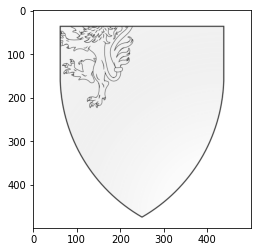

In [24]:
for i in range(1, 2):
    image_path = data_location + '/images/'+ df.iloc[i,0]
    print("Caption:", df.iloc[i,0], df.iloc[i,1])
    img=mpimg.imread(image_path)
    print(img.shape)
    plt.imshow(img)
    plt.show()


In [25]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [19]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [7]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-12GB'

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [ ]:
import torch.multiprocessing as mp

mp.set_start_method('spawn')

# Image Captioning With Attention - Pytorch

In [8]:
#setting the constants
BATCH_SIZE = 128
# BATCH_SIZE = 5
NUM_WORKER = 1 #### this needs multi-core
freq_threshold = 5
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}
        

## Calcualte the mean and std of training dataset

https://deeplizard.com/learn/video/lu7TCu7HeYc

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

In [20]:
def get_m(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    return mean, std

In [28]:
# improved after reading https://stackoverflow.com/a/61396543 and using https://github.com/szymonmaszke/torchdatasets

print_time('before')

train_loader, train_dataset = get_loader(
    root_folder=root_folder_images,
    annotation_file=train_annotation_file,
    transform=None,  # <=======================
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=512,
    device=device,
    pin_memory=True
)
print_time('after')

# Regular torch Dataset
# batch 128  = 35 minutes
# batch 512  = 15 minutes

# torchdatasets  with .map(torchvision.transforms.ToTensor()).cache()
# batch 512  = 13 minutes

# torchdatasets  with using cache to ram
# batch 512  = 15 minutes


before @ Time = 14:46:04


AttributeError: 'str' object has no attribute 'mkdir'

In [23]:
print_time('before')
mean, std = get_mean_std(train_dataset, train_loader, 500 , 500)
print('mean, std:', mean, std)
print_time('after')


before @ Time = 12:46:30
mean, std: tensor(0.8587) tensor(1.1624)
after @ Time = 12:47:53


In [22]:
print_time('before')
mean, std = get_m(train_loader )
print('mean, std:', mean, std)
print_time('after')


before @ Time = 12:45:31
mean, std: tensor([0.2903, 0.3006, 0.2678]) tensor([0.3048, 0.3074, 0.2730])
after @ Time = 12:46:17


In [38]:
#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std) 
])


In [39]:
#Initiate the Dataset and Dataloader
BATCH_SIZE = 56

# print_time('writing the dataloader')

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(
    root_folder=root_folder_images,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    device=device,
    pin_memory=False
)
len(train_loader), len(val_loader), len(test_loader), len(train_dataset), len(val_dataset), len(test_dataset)
# print_time('finished writing the dataloader')

(2, 1, 1, 82, 27, 28)

In [17]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'g': 4,
 'v': 5,
 'b': 6,
 'cross': 7,
 'lion': 8,
 'passt': 9,
 's': 10,
 'a': 11,
 'eagle': 12,
 'o': 13,
 'doubleheaded': 14,
 "'s": 15,
 'head': 16,
 'patonce': 17,
 'moline': 18,
 'guard': 19,
 'rampant': 20}

# Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
    

### Setting Hypperparameter and Init the model

In [41]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
drop_prob=0.3
ignored_idx = train_dataset.vocab.stoi["<PAD>"]

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocap_size': vocab_size
              }
#initialize new model, loss etc
model, optimizer, criterion = get_new_model(embed_size, vocab_size, attention_dim, encoder_dim,
                                            decoder_dim, learning_rate,drop_prob,ignored_idx, device)

## Training Job from above configs

In [42]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

In [43]:
losses = list()
losses_batch = list()
val_losses = list()
accuracy_list = list()

model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_ac12c.pth'
num_epochs = 5
print_every = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# if model is None:

for epoch in range(1, num_epochs + 1): 
#     if model is None:
#         model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)

    with tqdm(train_loader, unit="batch") as tepoch:
        idx = 0
        for image, captions in tepoch:
            idx+=1
            tepoch.set_description(f"Epoch {epoch}")
            image, captions = image.to(device), captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()
            
            # Feed forward
            outputs, attentions = model(image, captions.T)
            
            # Calculate the batch loss.
            targets = captions.T[:,1:]  ####### the fix in here
#             print(targets)
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
#             print(outputs.view(-1, vocab_size))
            
            # Backward pass. 
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
 
            avg_val_loss, bleu_score, accuracy = validate_model(model, criterion, val_loader, val_dataset, vocab_size, device)
            model.train()
#             tepoch.set_postfix(accuracy=accuracy)
#             tepoch.set_postfix(vallidation_loss=avg_val_loss)

            losses_batch.append(loss) # in here 17 batches * 5 epochs = 85 , you can get the average
            val_losses.append(avg_val_loss)
            accuracy_list.append(accuracy)
        
        avg_batch_loss = sum(losses_batch) / len(losses_batch)
        losses.append(avg_batch_loss)
            
accuracy = sum(accuracy_list)/len(accuracy_list)

print('Bleu Score: ',bleu_score/8091)
print('Final accuracy: ', accuracy)

                
# save the latest model
save_model(model, optimizer, epoch, loss, accuracy, model_full_path, hyper_params)


cuda


Epoch 5: 100%|████| 2/2 [00:01<00:00,  1.03batch/s, loss=1.58]


Bleu Score:  5.112959399858763e-05
Final accuracy:  28.35


In [22]:
# losses = list()
# for epoch in tqdm(range(5)):
#     epoch_losses = train_epoch(model, device, train_loader, optimizer)
#     print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
#     losses.extend(epoch_losses)
len(losses)


5

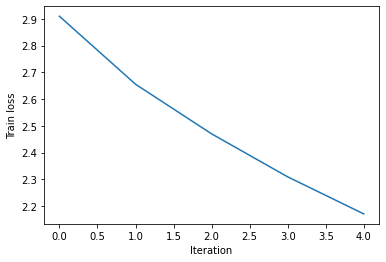

In [23]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()

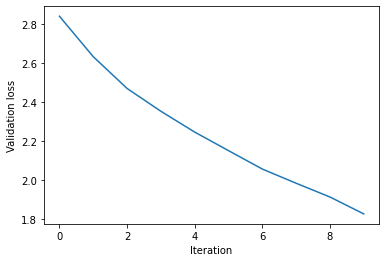

In [24]:
plt.plot(val_losses)
plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.show()

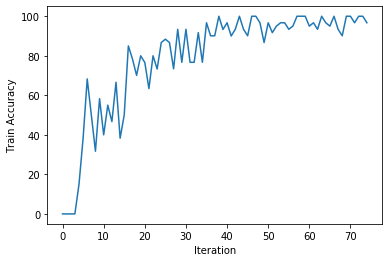

In [28]:
plt.plot(accuracy_list)
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.show()

In [ ]:
torch.cuda.empty_cache()


##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [29]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)
    


In [ ]:
# torch.cuda.empty_cache()

# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# local_model_path = 'simple-model.pth'
# model = load_model(local_model_path)
test_rand_image(model)